In [1]:
import sys
sys.path.append('../code')
from resnet import *
from funcs import *
from cifar_very_tiny import *
from cifar_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
from PIL import Image
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого

train_loader_no_augumentation, test_loader = cifar10_loader(batch_size=128, split_train_val=False,
                                                                             maxsize=128*100, use_aug=False)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
epoch_num = 50
# epoch_num = 50

run_num = 1 # количество запусков эксперимента

# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '2'

validate_every_epoch = 5 

# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
train_splines_every_epoch = 10

# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10

start_beta = 0.5
start_temp  = 1.0

In [6]:
student = Cifar_Very_Tiny(10).cpu()
teacher = Cifar_Tiny(10).cpu()    # teacher = ResNet18(10).cpu()
#scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)   
mu_feat = nn.Linear(128, 64).cpu()
log_sigma_feat = torch.nn.Parameter(torch.zeros(1).cpu())
optim = torch.optim.Adam(list(student.parameters()) + list(mu_feat.parameters()) + [log_sigma_feat])    

crit = nn.CrossEntropyLoss()

for e in range(25):
    tq = tqdm.tqdm(train_loader_no_augumentation)
    losses = []
            
    for batch_id, (x,y) in enumerate(tq):
        x = x.to(device)
        y = y.to(device)
        optim.zero_grad()
        student_feat, student_logits = student.get_features(x, [3,4])
        teacher_feat, teacher_logits = teacher.get_features(x, [3,4])
        class_loss = crit(student_logits, y)
        sigma2 = torch.log(1+torch.exp(log_sigma_feat))
        feat_loss = ((mu_feat(teacher_feat) - student_feat)**2).sum(1).mean()/sigma2 + torch.log(sigma2)*np.prod(teacher_feat.shape[1:])
        loss = class_loss * 0.9# + feat_loss * 0.1
        
        loss.backward()
        optim.step()
        losses.append(loss.detach().cpu().numpy())
        tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))      
    student.eval()
    ac = float(accuracy(student, test_loader))
    print(e, ac)
    student.train()
    with open('../logs/acc_naive_'+experiment_version+'.txt','a') as out:
        out.write('{}: {}\n'.format(e, ac))

current loss:1.407785177230835:   2%|▏         | 2/100 [00:00<00:07, 12.99it/s]

0 0.4041999876499176


current loss:1.2047837972640991:   2%|▏         | 2/100 [00:00<00:07, 13.24it/s]

1 0.4722999930381775


current loss:1.0772325992584229:   2%|▏         | 2/100 [00:00<00:07, 13.40it/s]

2 0.5121999979019165


current loss:0.9911186695098877:   2%|▏         | 2/100 [00:00<00:07, 13.26it/s]

3 0.5292999744415283


current loss:0.9305613040924072:   2%|▏         | 2/100 [00:00<00:07, 12.98it/s]

4 0.5357000231742859


current loss:0.8870053887367249:   2%|▏         | 2/100 [00:00<00:07, 13.76it/s]

5 0.5440000295639038


current loss:0.8456747531890869:   2%|▏         | 2/100 [00:00<00:07, 13.33it/s]

6 0.5478000044822693


current loss:0.8124432563781738:   2%|▏         | 2/100 [00:00<00:07, 12.62it/s]

7 0.5582000017166138


current loss:0.7807217836380005:   2%|▏         | 2/100 [00:00<00:07, 12.87it/s]

8 0.557200014591217


current loss:0.7561680674552917:   2%|▏         | 2/100 [00:00<00:07, 13.24it/s]

9 0.5608999729156494


current loss:0.7334483861923218:   2%|▏         | 2/100 [00:00<00:07, 12.63it/s]

10 0.5584999918937683


current loss:0.7112316489219666:   2%|▏         | 2/100 [00:00<00:07, 12.94it/s]

11 0.5586000084877014


current loss:0.6946913003921509:   2%|▏         | 2/100 [00:00<00:07, 13.26it/s]

12 0.5580999851226807


current loss:0.67386794090271:   2%|▏         | 2/100 [00:00<00:07, 13.10it/s]

13 0.5654000043869019


current loss:0.6623833775520325:   2%|▏         | 2/100 [00:00<00:07, 12.81it/s]

14 0.5669000148773193


current loss:0.651323139667511:   2%|▏         | 2/100 [00:00<00:07, 13.10it/s]

15 0.5687999725341797


current loss:0.6368882656097412:   2%|▏         | 2/100 [00:00<00:07, 12.53it/s]

16 0.5684999823570251


current loss:0.6254451274871826:   2%|▏         | 2/100 [00:00<00:07, 13.04it/s]

17 0.5674999952316284


current loss:0.6189881563186646:   2%|▏         | 2/100 [00:00<00:07, 13.18it/s]

18 0.5676000118255615


current loss:0.6110802888870239:   2%|▏         | 2/100 [00:00<00:07, 13.21it/s]

19 0.5622000098228455


current loss:0.6047539710998535:   2%|▏         | 2/100 [00:00<00:07, 12.98it/s]

20 0.558899998664856


current loss:0.6037348508834839:   2%|▏         | 2/100 [00:00<00:07, 12.99it/s]

21 0.5566999912261963


current loss:0.585663914680481:   2%|▏         | 2/100 [00:00<00:07, 13.42it/s]

22 0.5561000108718872


current loss:0.5683373212814331:   2%|▏         | 2/100 [00:00<00:07, 13.01it/s]

23 0.5598999857902527


current loss:0.6710801124572754: 100%|██████████| 100/100 [00:07<00:00, 14.01it/s]


24 0.5616000294685364


In [7]:
!wget "https://github.com/passalis/pkth/blob/master/cifar10/models/tiny_cifar10.model?raw=true"

--2022-03-25 00:37:17--  https://github.com/passalis/pkth/blob/master/cifar10/models/tiny_cifar10.model?raw=true
Распознаётся github.com (github.com)… 140.82.121.4
Подключение к github.com (github.com)|140.82.121.4|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://github.com/passalis/pkth/raw/master/cifar10/models/tiny_cifar10.model [переход]
--2022-03-25 00:37:18--  https://github.com/passalis/pkth/raw/master/cifar10/models/tiny_cifar10.model
Повторное использование соединения с github.com:443.
HTTP-запрос отправлен. Ожидание ответа… 302 Found
Адрес: https://raw.githubusercontent.com/passalis/pkth/master/cifar10/models/tiny_cifar10.model [переход]
--2022-03-25 00:37:18--  https://raw.githubusercontent.com/passalis/pkth/master/cifar10/models/tiny_cifar10.model
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercont

In [8]:
crit = nn.CrossEntropyLoss()
for lam1 in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5]:
    student = Cifar_Very_Tiny(10).cpu()
    teacher = Cifar_Tiny(10).cpu() 
    teacher.load_state_dict(torch.load('tiny_cifar10.model?raw=true', map_location=torch.device('cpu')))
    #scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=10, gamma=0.5)   
    mu_feat = nn.Linear(128, 64).cpu()
    log_sigma_feat = torch.nn.Parameter(torch.zeros(1).cpu())

    #mu_logit = nn.Linear(10, 10).cpu()
    #log_sigma_logit = torch.nn.Parameter(torch.zeros(1).cpu())


    optim = torch.optim.Adam(list(student.parameters()) + list(mu_feat.parameters()) + [log_sigma_feat])    


    for e in range(25):
        tq = tqdm.tqdm(train_loader_no_augumentation)
        losses = []

        for batch_id, (x,y) in enumerate(tq):
            x = x.to(device)
            y = y.to(device)
            optim.zero_grad()
            student_feat, student_logits = student.get_features(x, [3,4])
            teacher_feat, teacher_logits = teacher.get_features(x, [3,4])
            class_loss = crit(student_logits, y)
            sigma2 = torch.log(1+torch.exp(log_sigma_feat))
            feat_loss = ((mu_feat(teacher_feat) - student_feat)**2).sum(1).mean()/(2*sigma2) + 0.5*torch.log(sigma2)*np.prod(teacher_feat.shape[1:])
            #logit_loss =((mu_feat(teacher_feat) - student_feat)**2).sum(1).mean()/(2*sigma2) + 0.5*torch.log(sigma2)*np.prod(teacher_feat.shape[1:])
            #lam1 = 0.5
            loss = class_loss * (1.0-lam1) + feat_loss * lam1


            loss.backward()
            optim.step()
            losses.append(loss.detach().cpu().numpy())
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))      
        #scheduler.step()
        student.eval()
        ac = float(accuracy(student, test_loader))
        print(e, ac)
        student.train()
        with open('../logs/acc_mi_'+experiment_version+'.txt','a') as out:
            out.write('{}: {}: {}\n'.format(lam1, e, ac))

current loss:1.6468515396118164:   1%|          | 1/100 [00:00<00:10,  9.03it/s]

0 0.42340001463890076


current loss:1.3939635753631592:   1%|          | 1/100 [00:00<00:10,  9.36it/s]

1 0.47609999775886536


current loss:1.2895413637161255:   1%|          | 1/100 [00:00<00:10,  9.14it/s]

2 0.49570000171661377


current loss:1.2075591087341309:   1%|          | 1/100 [00:00<00:10,  9.29it/s]

3 0.5109000205993652


current loss:1.1328452825546265:   1%|          | 1/100 [00:00<00:10,  9.14it/s]

4 0.5164999961853027


current loss:1.0757273435592651:   1%|          | 1/100 [00:00<00:10,  9.43it/s]

5 0.5234000086784363


current loss:1.022861361503601:   1%|          | 1/100 [00:00<00:10,  9.26it/s]

6 0.5328999757766724


current loss:0.9710783362388611:   1%|          | 1/100 [00:00<00:10,  9.09it/s]

7 0.5357999801635742


current loss:0.9344011545181274:   1%|          | 1/100 [00:00<00:10,  9.58it/s]

8 0.536899983882904


current loss:0.9045060873031616:   1%|          | 1/100 [00:00<00:10,  9.38it/s]

9 0.5378000140190125


current loss:0.8724483251571655:   1%|          | 1/100 [00:00<00:10,  9.06it/s]

10 0.5410000085830688


current loss:0.850023090839386:   1%|          | 1/100 [00:00<00:10,  9.41it/s]

11 0.5429999828338623


current loss:0.8170853853225708:   1%|          | 1/100 [00:00<00:10,  9.29it/s]

12 0.5421000123023987


current loss:0.7940247654914856:   1%|          | 1/100 [00:00<00:10,  9.20it/s]

13 0.5444999933242798


current loss:0.784217894077301:   1%|          | 1/100 [00:00<00:10,  9.52it/s]

14 0.546999990940094


current loss:0.7776188254356384:   1%|          | 1/100 [00:00<00:10,  9.52it/s]

15 0.5498999953269958


current loss:0.7513241171836853:   1%|          | 1/100 [00:00<00:10,  9.48it/s]

16 0.5569000244140625


current loss:0.7416008114814758:   1%|          | 1/100 [00:00<00:11,  8.62it/s]

17 0.5566999912261963


current loss:0.726120114326477:   1%|          | 1/100 [00:00<00:10,  9.32it/s]

18 0.5552999973297119


current loss:0.7040578126907349:   1%|          | 1/100 [00:00<00:10,  9.02it/s]

19 0.5569000244140625


current loss:0.6938878297805786:   1%|          | 1/100 [00:00<00:10,  9.25it/s]

20 0.5547999739646912


current loss:0.6744919419288635:   1%|          | 1/100 [00:00<00:10,  9.14it/s]

21 0.5512999892234802


current loss:0.6600759625434875:   1%|          | 1/100 [00:00<00:10,  9.29it/s]

22 0.5507000088691711


current loss:0.6530033946037292:   1%|          | 1/100 [00:00<00:10,  9.26it/s]

23 0.5512999892234802


current loss:2.365229368209839:   1%|          | 1/100 [00:00<00:10,  9.05it/s]

24 0.5501000285148621


current loss:1.5851750373840332:   1%|          | 1/100 [00:00<00:11,  8.67it/s]

0 0.4090000092983246


current loss:1.3781760931015015:   1%|          | 1/100 [00:00<00:11,  8.77it/s]

1 0.47099998593330383


current loss:1.255471110343933:   1%|          | 1/100 [00:00<00:11,  8.57it/s]

2 0.49799999594688416


current loss:1.150338888168335:   1%|          | 1/100 [00:00<00:11,  8.71it/s]

3 0.5178999900817871


current loss:1.0848429203033447:   1%|          | 1/100 [00:00<00:11,  8.82it/s]

4 0.5299999713897705


current loss:1.0172861814498901:   1%|          | 1/100 [00:00<00:11,  8.72it/s]

5 0.5350000262260437


current loss:0.9667216539382935:   1%|          | 1/100 [00:00<00:11,  8.44it/s]

6 0.5446000099182129


current loss:0.9237672090530396:   1%|          | 1/100 [00:00<00:11,  8.39it/s]

7 0.5516999959945679


current loss:0.8990709185600281:   1%|          | 1/100 [00:00<00:11,  8.87it/s]

8 0.5554999709129333


current loss:0.8720543384552002:   1%|          | 1/100 [00:00<00:10,  9.05it/s]

9 0.5613999962806702


current loss:0.8435720801353455:   1%|          | 1/100 [00:00<00:10,  9.28it/s]

10 0.5601999759674072


current loss:0.8145880103111267:   1%|          | 1/100 [00:00<00:11,  8.99it/s]

11 0.5631999969482422


current loss:0.7924824357032776:   1%|          | 1/100 [00:00<00:11,  8.88it/s]

12 0.5677000284194946


current loss:0.7687509655952454:   1%|          | 1/100 [00:00<00:11,  8.26it/s]

13 0.569100022315979


current loss:0.747303307056427:   1%|          | 1/100 [00:00<00:11,  8.53it/s]

14 0.5684999823570251


current loss:0.7337961196899414:   1%|          | 1/100 [00:00<00:14,  6.64it/s]

15 0.5654000043869019


current loss:0.719244658946991:   1%|          | 1/100 [00:00<00:11,  8.77it/s]

16 0.5618000030517578


current loss:0.7014654874801636:   1%|          | 1/100 [00:00<00:12,  8.02it/s]

17 0.5602999925613403


current loss:0.6861785650253296:   1%|          | 1/100 [00:00<00:11,  8.79it/s]

18 0.5569999814033508


current loss:0.6615229249000549:   1%|          | 1/100 [00:00<00:12,  8.04it/s]

19 0.5555999875068665


current loss:0.6456042528152466:   1%|          | 1/100 [00:00<00:11,  8.43it/s]

20 0.5548999905586243


current loss:0.6280951499938965:   1%|          | 1/100 [00:00<00:11,  8.36it/s]

21 0.5551999807357788


current loss:0.6118118762969971:   1%|          | 1/100 [00:00<00:11,  8.64it/s]

22 0.5546000003814697


current loss:0.6033750176429749:   1%|          | 1/100 [00:00<00:11,  8.37it/s]

23 0.5550000071525574


current loss:2.333857536315918:   1%|          | 1/100 [00:00<00:11,  8.32it/s]

24 0.5548999905586243


current loss:1.5822651386260986:   1%|          | 1/100 [00:00<00:12,  7.97it/s]

0 0.41350001096725464


current loss:1.3702014684677124:   1%|          | 1/100 [00:00<00:11,  8.47it/s]

1 0.4625999927520752


current loss:1.2319245338439941:   1%|          | 1/100 [00:00<00:11,  8.70it/s]

2 0.48190000653266907


current loss:1.1269664764404297:   1%|          | 1/100 [00:00<00:11,  8.62it/s]

3 0.503000020980835


current loss:1.0425132513046265:   1%|          | 1/100 [00:00<00:12,  7.80it/s]

4 0.5216000080108643


current loss:0.9888718128204346:   1%|          | 1/100 [00:00<00:12,  7.96it/s]

5 0.5357999801635742


  0%|          | 0/100 [00:00<?, ?it/s]

6 0.5444999933242798


  0%|          | 0/100 [00:00<?, ?it/s]

7 0.5468999743461609


current loss:0.9149447083473206:   1%|          | 1/100 [00:00<00:16,  6.08it/s]

8 0.5515999794006348


current loss:0.8836966156959534:   1%|          | 1/100 [00:00<00:13,  7.60it/s]

9 0.5601999759674072


current loss:0.8566761612892151:   1%|          | 1/100 [00:00<00:12,  7.84it/s]

10 0.5658000111579895


current loss:0.8369999527931213:   1%|          | 1/100 [00:00<00:12,  7.70it/s]

11 0.5669000148773193


current loss:0.8118513822555542:   1%|          | 1/100 [00:00<00:16,  5.94it/s]

12 0.5690000057220459


current loss:0.7893187403678894:   1%|          | 1/100 [00:00<00:13,  7.30it/s]

13 0.567300021648407


current loss:0.7742751240730286:   1%|          | 1/100 [00:00<00:12,  7.92it/s]

14 0.5677000284194946


current loss:0.7684154510498047:   1%|          | 1/100 [00:00<00:14,  6.94it/s]

15 0.5684999823570251


current loss:0.756191074848175:   1%|          | 1/100 [00:00<00:12,  8.15it/s]

16 0.5685999989509583


current loss:0.7447925209999084:   1%|          | 1/100 [00:00<00:12,  7.93it/s]

17 0.5649999976158142


current loss:0.7444140315055847:   1%|          | 1/100 [00:00<00:12,  8.09it/s]

18 0.5633000135421753


current loss:0.7421157956123352:   1%|          | 1/100 [00:00<00:12,  8.14it/s]

19 0.5612999796867371


current loss:0.743183970451355:   1%|          | 1/100 [00:00<00:11,  8.53it/s]

20 0.5595999956130981


current loss:0.7407582998275757:   1%|          | 1/100 [00:00<00:12,  7.89it/s]

21 0.5598000288009644


current loss:0.7406168580055237:   1%|          | 1/100 [00:00<00:12,  8.25it/s]

22 0.5548999905586243


current loss:0.7350092530250549:   1%|          | 1/100 [00:00<00:12,  7.77it/s]

23 0.554099977016449


current loss:2.3181731700897217:   1%|          | 1/100 [00:00<00:13,  7.20it/s]

24 0.5527999997138977


current loss:1.5353200435638428:   1%|          | 1/100 [00:00<00:15,  6.37it/s]

0 0.41769999265670776


current loss:1.3499135971069336:   1%|          | 1/100 [00:00<00:14,  6.74it/s]

1 0.49709999561309814


current loss:1.2306221723556519:   1%|          | 1/100 [00:00<00:14,  7.01it/s]

2 0.5188999772071838


  0%|          | 0/100 [00:00<?, ?it/s]

3 0.5231999754905701


current loss:1.0455149412155151:   1%|          | 1/100 [00:00<00:14,  6.88it/s]

4 0.5209000110626221


current loss:0.9649094939231873:   1%|          | 1/100 [00:00<00:14,  6.99it/s]

5 0.5188999772071838


  0%|          | 0/100 [00:00<?, ?it/s]

6 0.534600019454956


current loss:0.8620009422302246:   1%|          | 1/100 [00:00<00:14,  7.07it/s]

7 0.5462999939918518


current loss:0.8260765075683594:   1%|          | 1/100 [00:00<00:14,  6.68it/s]

8 0.5539000034332275


current loss:0.8014460206031799:   1%|          | 1/100 [00:00<00:14,  6.80it/s]

9 0.5533000230789185


current loss:0.7723689079284668:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

10 0.5569000244140625


current loss:0.74223393201828:   1%|          | 1/100 [00:00<00:12,  7.67it/s]

11 0.5561000108718872


current loss:0.7275134921073914:   1%|          | 1/100 [00:00<00:13,  7.28it/s]

12 0.5616000294685364


current loss:0.7104253768920898:   1%|          | 1/100 [00:00<00:11,  8.59it/s]

13 0.564300000667572


current loss:0.6968069672584534:   1%|          | 1/100 [00:00<00:16,  5.84it/s]

14 0.5641999840736389


current loss:0.6832237839698792:   1%|          | 1/100 [00:00<00:14,  7.02it/s]

15 0.5608000159263611


current loss:0.679894745349884:   1%|          | 1/100 [00:00<00:15,  6.48it/s]

16 0.5652999877929688


current loss:0.6749023795127869:   1%|          | 1/100 [00:00<00:12,  7.63it/s]

17 0.5633000135421753


current loss:0.6680524349212646:   1%|          | 1/100 [00:00<00:15,  6.58it/s]

18 0.5633000135421753


  0%|          | 0/100 [00:00<?, ?it/s]

19 0.5670999884605408


current loss:0.6418870091438293:   1%|          | 1/100 [00:00<00:18,  5.46it/s]

20 0.5685999989509583


current loss:0.6277114152908325:   1%|          | 1/100 [00:00<00:12,  8.11it/s]

21 0.5687000155448914


current loss:0.6224641799926758:   1%|          | 1/100 [00:00<00:12,  7.96it/s]

22 0.569100022315979


current loss:0.6137473583221436:   1%|          | 1/100 [00:00<00:12,  7.93it/s]

23 0.5690000057220459


current loss:2.3365142345428467:   1%|          | 1/100 [00:00<00:11,  8.42it/s]

24 0.5684999823570251


current loss:1.6507104635238647:   1%|          | 1/100 [00:00<00:13,  7.18it/s]

0 0.4262000024318695


current loss:1.432011365890503:   1%|          | 1/100 [00:00<00:18,  5.45it/s]

1 0.48069998621940613


current loss:1.2849376201629639:   1%|          | 1/100 [00:00<00:13,  7.40it/s]

2 0.5044000148773193


current loss:1.176835536956787:   1%|          | 1/100 [00:00<00:12,  7.71it/s]

3 0.5217000246047974


current loss:1.099736213684082:   1%|          | 1/100 [00:00<00:13,  7.28it/s]

4 0.5353999733924866


current loss:1.0333192348480225:   1%|          | 1/100 [00:00<00:15,  6.30it/s]

5 0.5430999994277954


current loss:0.991197407245636:   1%|          | 1/100 [00:00<00:12,  8.20it/s]

6 0.5490000247955322


current loss:0.9410219192504883:   1%|          | 1/100 [00:00<00:12,  7.72it/s]

7 0.5565999746322632


current loss:0.8897621631622314:   1%|          | 1/100 [00:00<00:18,  5.49it/s]

8 0.5609999895095825


current loss:0.8458153605461121:   1%|          | 1/100 [00:00<00:14,  6.86it/s]

9 0.5619999766349792


current loss:0.8185809850692749:   1%|          | 1/100 [00:00<00:12,  7.88it/s]

10 0.5608999729156494


current loss:0.7855757474899292:   1%|          | 1/100 [00:00<00:11,  8.27it/s]

11 0.5662999749183655


current loss:0.768722414970398:   1%|          | 1/100 [00:00<00:15,  6.25it/s]

12 0.5648000240325928


current loss:0.7453545331954956:   1%|          | 1/100 [00:00<00:13,  7.26it/s]

13 0.5647000074386597


current loss:0.7230491042137146:   1%|          | 1/100 [00:00<00:12,  7.87it/s]

14 0.5601000189781189


current loss:0.6993706226348877:   1%|          | 1/100 [00:00<00:17,  5.58it/s]

15 0.5577999949455261


current loss:0.67134690284729:   1%|          | 1/100 [00:00<00:12,  8.13it/s]

16 0.5623000264167786


current loss:0.6592540740966797:   1%|          | 1/100 [00:00<00:12,  8.03it/s]

17 0.557200014591217


current loss:0.6389356851577759:   1%|          | 1/100 [00:00<00:12,  8.11it/s]

18 0.557200014591217


current loss:0.6245800852775574:   1%|          | 1/100 [00:00<00:12,  8.00it/s]

19 0.5569000244140625


current loss:0.6124009490013123:   1%|          | 1/100 [00:00<00:11,  8.89it/s]

20 0.5548999905586243


current loss:0.5918949246406555:   1%|          | 1/100 [00:00<00:12,  7.91it/s]

21 0.5550000071525574


  0%|          | 0/100 [00:00<?, ?it/s]

22 0.555899977684021


current loss:0.55098956823349:   1%|          | 1/100 [00:00<00:12,  7.82it/s]

23 0.5526000261306763


current loss:2.2841274738311768:   1%|          | 1/100 [00:00<00:13,  7.17it/s]

24 0.5605000257492065


current loss:1.4394327402114868:   1%|          | 1/100 [00:00<00:11,  8.45it/s]

0 0.4117000102996826


current loss:1.205754041671753:   1%|          | 1/100 [00:00<00:13,  7.45it/s]

1 0.46470001339912415


current loss:1.0912669897079468:   1%|          | 1/100 [00:00<00:11,  8.78it/s]

2 0.4952000081539154


current loss:0.978111982345581:   1%|          | 1/100 [00:00<00:11,  8.70it/s]

3 0.5131000280380249


current loss:0.8607178926467896:   1%|          | 1/100 [00:00<00:12,  8.05it/s]

4 0.5260999798774719


current loss:0.7478348016738892:   1%|          | 1/100 [00:00<00:17,  5.63it/s]

5 0.5358999967575073


current loss:0.650833010673523:   1%|          | 1/100 [00:00<00:11,  8.43it/s]

6 0.5361999869346619


current loss:0.5505039095878601:   1%|          | 1/100 [00:00<00:12,  7.98it/s]

7 0.5450000166893005


current loss:0.460582971572876:   1%|          | 1/100 [00:00<00:13,  7.50it/s]

8 0.550000011920929


current loss:0.3637717366218567:   1%|          | 1/100 [00:00<00:12,  7.98it/s]

9 0.5575000047683716


current loss:0.27576184272766113:   1%|          | 1/100 [00:00<00:12,  8.12it/s]

10 0.5584999918937683


current loss:0.19185584783554077:   1%|          | 1/100 [00:00<00:12,  7.83it/s]

11 0.555400013923645


current loss:0.1173134446144104:   1%|          | 1/100 [00:00<00:13,  7.08it/s]

12 0.5558000206947327


current loss:0.02825295925140381:   1%|          | 1/100 [00:00<00:12,  7.69it/s]

13 0.5544999837875366


current loss:-0.043862342834472656:   1%|          | 1/100 [00:00<00:14,  6.83it/s]

14 0.5546000003814697


current loss:-0.11403530836105347:   1%|          | 1/100 [00:00<00:13,  7.36it/s]

15 0.5555999875068665


current loss:-0.17959505319595337:   1%|          | 1/100 [00:00<00:13,  7.61it/s]

16 0.5519999861717224


current loss:-0.24783265590667725:   1%|          | 1/100 [00:00<00:11,  8.39it/s]

17 0.5522000193595886


current loss:-0.30636119842529297:   1%|          | 1/100 [00:00<00:11,  8.47it/s]

18 0.550000011920929


current loss:-0.37491703033447266:   1%|          | 1/100 [00:00<00:17,  5.64it/s]

19 0.5468999743461609


current loss:-0.4413852095603943:   1%|          | 1/100 [00:00<00:15,  6.22it/s]

20 0.5468000173568726


current loss:-0.5103020668029785:   1%|          | 1/100 [00:00<00:12,  7.83it/s]

21 0.5461000204086304


current loss:-0.5759329199790955:   1%|          | 1/100 [00:00<00:12,  7.83it/s]

22 0.5454000234603882


current loss:-0.6345391869544983:   1%|          | 1/100 [00:00<00:13,  7.55it/s]

23 0.5437999963760376


current loss:2.670300245285034:   1%|          | 1/100 [00:00<00:13,  7.61it/s]

24 0.5436999797821045


current loss:-0.7643582820892334:   1%|          | 1/100 [00:00<00:12,  7.77it/s]

0 0.2809000015258789


current loss:-1.515284538269043:   1%|          | 1/100 [00:00<00:12,  7.84it/s]

1 0.3578000068664551


current loss:-2.2001094818115234:   1%|          | 1/100 [00:00<00:12,  7.62it/s]

2 0.4214000105857849


current loss:-2.847034454345703:   1%|          | 1/100 [00:00<00:13,  7.60it/s]

3 0.4602999985218048


current loss:-3.466503143310547:   1%|          | 1/100 [00:00<00:14,  6.90it/s]

4 0.48669999837875366


current loss:-4.0809245109558105:   1%|          | 1/100 [00:00<00:12,  7.79it/s]

5 0.508400022983551


current loss:-4.696295738220215:   1%|          | 1/100 [00:00<00:13,  7.24it/s]

6 0.5249999761581421


current loss:-5.317046642303467:   1%|          | 1/100 [00:00<00:11,  8.42it/s]

7 0.5302000045776367


current loss:-5.931896209716797:   1%|          | 1/100 [00:00<00:12,  8.02it/s]

8 0.5407000184059143


current loss:-6.551932334899902:   1%|          | 1/100 [00:00<00:16,  6.03it/s]

9 0.546500027179718


current loss:-7.167335510253906:   1%|          | 1/100 [00:00<00:11,  8.36it/s]

10 0.5515000224113464


current loss:-7.790065765380859:   1%|          | 1/100 [00:00<00:16,  6.08it/s]

11 0.5555999875068665


current loss:-8.419011116027832:   1%|          | 1/100 [00:00<00:14,  7.06it/s]

12 0.5580000281333923


current loss:-9.044344902038574:   1%|          | 1/100 [00:00<00:12,  8.15it/s]

13 0.5600000023841858


current loss:-9.672759056091309:   1%|          | 1/100 [00:00<00:12,  7.85it/s]

14 0.5619000196456909


current loss:-10.308847427368164:   1%|          | 1/100 [00:00<00:12,  7.69it/s]

15 0.5662000179290771


current loss:-10.950491905212402:   1%|          | 1/100 [00:00<00:11,  8.62it/s]

16 0.5667999982833862


current loss:-11.597225189208984:   1%|          | 1/100 [00:00<00:11,  8.70it/s]

17 0.5680000185966492


current loss:-12.243083953857422:   1%|          | 1/100 [00:00<00:12,  7.82it/s]

18 0.5687999725341797


current loss:-12.885461807250977:   1%|          | 1/100 [00:00<00:12,  8.22it/s]

19 0.5708000063896179


current loss:-13.524553298950195:   1%|          | 1/100 [00:00<00:15,  6.49it/s]

20 0.5684999823570251


current loss:-14.161989212036133:   1%|          | 1/100 [00:00<00:18,  5.25it/s]

21 0.570900022983551


  0%|          | 0/100 [00:00<?, ?it/s]

22 0.5698000192642212


  0%|          | 0/100 [00:00<?, ?it/s]

23 0.5684999823570251


current loss:0.8997766971588135:   1%|          | 1/100 [00:00<00:13,  7.53it/s]

24 0.5680000185966492


current loss:-12.328622817993164:   1%|          | 1/100 [00:00<00:11,  8.35it/s]

0 0.13779999315738678


current loss:-15.265424728393555:   1%|          | 1/100 [00:00<00:12,  7.79it/s]

1 0.1200999990105629


current loss:-17.956668853759766:   1%|          | 1/100 [00:00<00:12,  8.06it/s]

2 0.1347000002861023


current loss:-20.61923599243164:   1%|          | 1/100 [00:00<00:12,  7.69it/s]

3 0.1598999947309494


current loss:-23.31342124938965:   1%|          | 1/100 [00:00<00:15,  6.39it/s]

4 0.17000000178813934


current loss:-26.072101593017578:   1%|          | 1/100 [00:00<00:18,  5.28it/s]

5 0.1590999960899353


  0%|          | 0/100 [00:00<?, ?it/s]

6 0.18219999969005585


current loss:-31.739980697631836:   1%|          | 1/100 [00:00<00:12,  7.72it/s]

7 0.20100000500679016


current loss:-34.647735595703125:   1%|          | 1/100 [00:00<00:18,  5.42it/s]

8 0.23489999771118164


current loss:-37.59855651855469:   1%|          | 1/100 [00:00<00:11,  8.49it/s]

9 0.25189998745918274


current loss:-40.59577941894531:   1%|          | 1/100 [00:00<00:16,  5.93it/s]

10 0.26579999923706055


  0%|          | 0/100 [00:00<?, ?it/s]

11 0.27149999141693115


current loss:-46.692989349365234:   1%|          | 1/100 [00:00<00:11,  8.39it/s]

12 0.2761000096797943


current loss:-49.78963851928711:   1%|          | 1/100 [00:00<00:13,  7.49it/s]

13 0.2791999876499176


current loss:-52.91908645629883:   1%|          | 1/100 [00:00<00:12,  7.77it/s]

14 0.2831000089645386


  0%|          | 0/100 [00:00<?, ?it/s]

15 0.2838999927043915


  0%|          | 0/100 [00:00<?, ?it/s]

16 0.2865000069141388


  0%|          | 0/100 [00:00<?, ?it/s]

17 0.2854999899864197


  0%|          | 0/100 [00:00<?, ?it/s]

18 0.2833000123500824


current loss:-68.8369369506836:   1%|          | 1/100 [00:00<00:16,  6.02it/s]

19 0.28139999508857727


current loss:-72.05664825439453:   1%|          | 1/100 [00:00<00:16,  5.98it/s]

20 0.2849999964237213


current loss:-75.2877426147461:   1%|          | 1/100 [00:00<00:15,  6.51it/s]

21 0.2863999903202057


current loss:-78.52821350097656:   1%|          | 1/100 [00:00<00:13,  7.24it/s]

22 0.28839999437332153


current loss:-81.76729583740234:   1%|          | 1/100 [00:00<00:11,  8.61it/s]

23 0.28679999709129333


current loss:-84.84751892089844: 100%|██████████| 100/100 [00:11<00:00,  8.58it/s]


24 0.29109999537467957


In [21]:
path = '../logs/acc_mi_'+experiment_version+'.txt'

with open(path, "r") as read_file:
    data = [float(line.split()[2]) for line in read_file]

In [22]:
data = np.reshape(np.array(data), (-1, 25))

In [27]:
from matplotlib import pylab as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

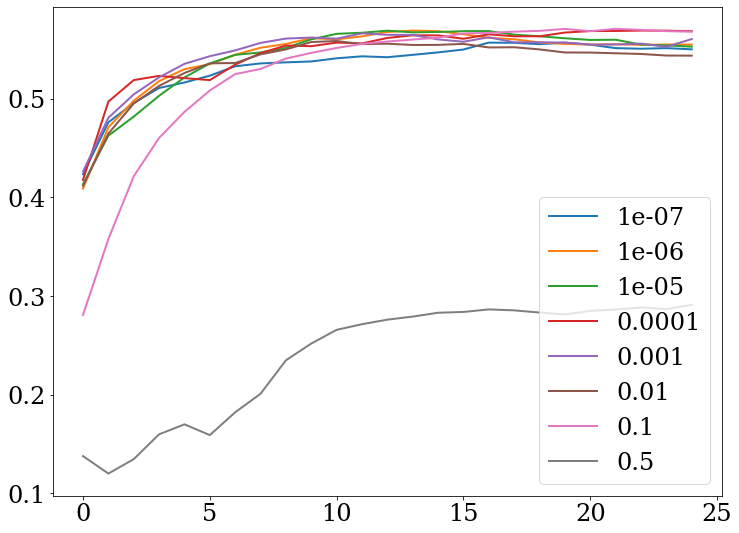

In [38]:
lambdas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5]

for i in range(8):
    plt.plot(data[i], label=str(lambdas[i]))
    plt.legend()